In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!cp -r /content/drive/MyDrive/rafdb /content/rafdb

In [5]:
TRAIN_DIR = "/content/drive/MyDrive/rafdb/train"
TEST_DIR  = "/content/drive/MyDrive/rafdb/test"

In [6]:
!ls /content/drive/MyDrive/rafdb/train

Angry  Happy  Neutral  Sad  Surprise


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix

In [12]:
import tensorflow as tf
train_data = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=(224,224),
    batch_size=64,
    label_mode="categorical",
    shuffle=True
)

test_data = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=(224,224),
    batch_size=64,
    label_mode="categorical",
    shuffle=False
)

class_names = train_data.class_names
NUM_CLASSES = len(class_names)
class_names

from tensorflow.keras.applications.resnet50 import preprocess_input

train_data = train_data.map(
    lambda x, y: (preprocess_input(x), y)
)

test_data = test_data.map(
    lambda x, y: (preprocess_input(x), y)
)


train_data = train_data.prefetch(tf.data.AUTOTUNE)
test_data  = test_data.prefetch(tf.data.AUTOTUNE)

Found 11286 files belonging to 5 classes.
Found 2841 files belonging to 5 classes.


In [13]:
from sklearn.utils.class_weight import compute_class_weight

# Extract all labels from tf.data.Dataset
y_train = np.concatenate([
    np.argmax(y.numpy(), axis=1)
    for _, y in train_data
])

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights))
class_weights


{0: np.float64(3.2017021276595745),
 1: np.float64(0.4718227424749164),
 2: np.float64(0.8942947702060222),
 3: np.float64(1.1382753403933434),
 4: np.float64(1.7497674418604652)}

In [10]:
class_names = ['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']

In [14]:
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,113,541 (91.99 MB)

 Trainable params: 525,829 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [15]:
model.fit(
    train_data,
    epochs=12,
    validation_data=test_data,
    class_weight=class_weights
)

Epoch 1/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 94s 415ms/step - accuracy: 0.3032 - loss: 1.7426 - val_accuracy: 0.5495 - val_loss: 1.2017
Epoch 2/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 61s 343ms/step - accuracy: 0.5013 - loss: 1.2810 - val_accuracy: 0.5949 - val_loss: 1.1116
Epoch 3/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 60s 339ms/step - accuracy: 0.5509 - loss: 1.1585 - val_accuracy: 0.6181 - val_loss: 1.0466
Epoch 4/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 82s 340ms/step - accuracy: 0.5868 - loss: 1.0715 - val_accuracy: 0.6234 - val_loss: 1.0137
Epoch 5/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 88s 375ms/step - accuracy: 0.6021 - loss: 1.0361 - val_accuracy: 0.6427 - val_loss: 0.9637
Epoch 6/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 77s 347ms/step - accuracy: 0.6203 - loss: 0.9783 - val_accuracy: 0.6406 - val_loss: 0.9603
Epoch 7/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 60s 339ms/step - accuracy: 0.6321 - loss: 0.9483 - val_accuracy: 0.6491 - val_loss: 0.9374
Epoch 8/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 61s 345ms/step - accuracy: 0.6502 - loss: 0

In [17]:
for layer in base_model.layers[-40:]:
    layer.trainable = True

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/resnet50_best_new.keras",
    monitor="val_loss",
    save_best_only=True
)

history_fine = model.fit(
    train_data,
    validation_data=test_data,
    epochs=25,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 62s 346ms/step - accuracy: 0.7363 - loss: 0.6993 - val_accuracy: 0.6786 - val_loss: 0.8525
Epoch 2/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 64s 357ms/step - accuracy: 0.7382 - loss: 0.6673 - val_accuracy: 0.6913 - val_loss: 0.8221
Epoch 3/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 64s 360ms/step - accuracy: 0.7483 - loss: 0.6494 - val_accuracy: 0.6980 - val_loss: 0.8005
Epoch 4/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 64s 356ms/step - accuracy: 0.7578 - loss: 0.6180 - val_accuracy: 0.6846 - val_loss: 0.8263
Epoch 5/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 72s 408ms/step - accuracy: 0.7613 - loss: 0.6167 - val_accuracy: 0.7043 - val_loss: 0.7892
Epoch 6/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 64s 361ms/step - accuracy: 0.7684 - loss: 0.5888 - val_accuracy: 0.6941 - val_loss: 0.8003
Epoch 7/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 63s 354ms/step - accuracy: 0.7707 - loss: 0.5785 - val_accuracy: 0.7103 - val_loss: 0.7836
Epoch 8/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 63s 349ms/step - accuracy: 0.7841 - loss: 0

In [18]:
from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/resnet50_best_new.keras")

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 106 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

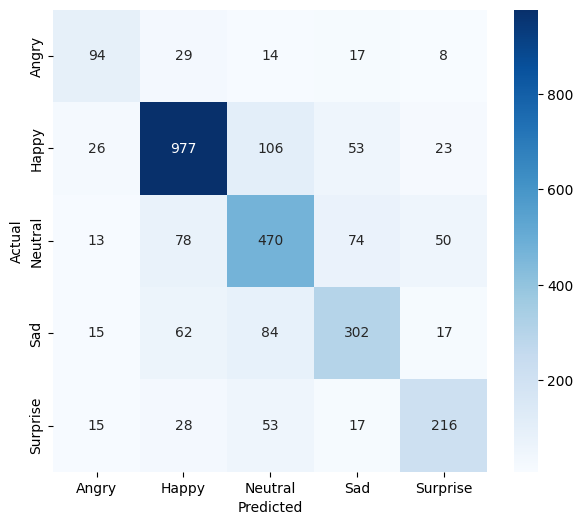

In [19]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true, y_pred = [], []

for x, y in test_data:
    preds = model.predict(x)
    y_true.extend(np.argmax(y.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()